#### Import CSV and Dependencies

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
filename = "Data/shootingSets2019-2020.csv"
rawData = pd.read_csv(filename)

#### Data Filtering
I want to use the TEAM_NAME column to see if the game is held at a home game for the player making the shot.

In [3]:
from nba_api.stats.static import teams

i = 0
rawData["HOME"] = np.where((rawData.HTM == "LA Clippers"), "Los Angeles Clippers", rawData.HTM)
def homeOrAway(row):
    if(teams.find_teams_by_full_name(row.TEAM_NAME)):
        return int(teams.find_teams_by_full_name(row.TEAM_NAME)[0]["abbreviation"] == row.HTM)

rawData["HOME"] = rawData.apply(homeOrAway, axis=1)

Drop unused columns and change the GAME_DATE from YYYYMMDD to a YEAR, MONTH, DATE column. The year portion is not relevant because it is known that the data is from the 2018-2019 season

In [4]:
trimmedData = rawData.drop(
    ["GAME_ID", "GRID_TYPE", "PLAYER_ID", "PLAYER_NAME", "TEAM_ID", "TEAM_NAME", "EVENT_TYPE", 
     "SHOT_ATTEMPTED_FLAG", "GAME_EVENT_ID", "HTM", "VTM"],1)

dateTimes = pd.to_datetime(trimmedData["GAME_DATE"], format='%Y%m%d')
trimmedData["GAME_DATE"] = dateTimes
trimmedData["MONTH"] = trimmedData["GAME_DATE"].dt.month
trimmedData["DAY"] = trimmedData["GAME_DATE"].dt.day

trimmedData = trimmedData.drop("GAME_DATE",1)

shootingSets2019-2020.csv contains roughly 220000 rows. So running a model on it would take a very long time. It was found reducing the model to a quarter of its size would decrease the computation time to a manageable value.

In [5]:
trimmedData = trimmedData.iloc[::4, :]
trimmedData = trimmedData.dropna()

#### Data Visualisation

Plotting LOC_X vs LOC_Y to get a representation of shots made and whether if it went in or not

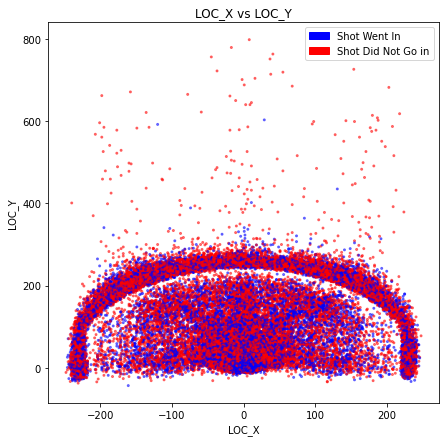

In [6]:
import matplotlib.patches as mpatches
redPatch = mpatches.Patch(color="Blue", label="Shot Went In")
bluePatch = mpatches.Patch(color="Red", label="Shot Did Not Go in")
plt.figure(figsize=(7,7))
colors = np.where(trimmedData["SHOT_MADE_FLAG"]==1, "Blue", "Red")
colors.shape

plt.title("LOC_X vs LOC_Y")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
plt.legend(handles=[redPatch, bluePatch])
plt.scatter(trimmedData.LOC_X, trimmedData.LOC_Y, color=colors, s=4, alpha=0.5)

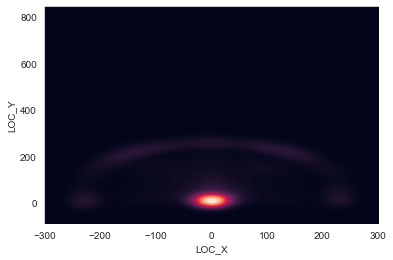

In [7]:
sns.set_style("dark")
jointPlot = sns.kdeplot(data=trimmedData, x="LOC_X", y="LOC_Y",
                        fill=True, thresh=0, levels=100, cmap="rocket")

Now plotting various points to view distances and shot zones

In [ ]:
plt.figure(figsize=(15, 7))
def groupedPlotByFeatureAndColorset(feature, color):
    patches = []
    datasets = trimmedData.groupby(feature)
    colors = color(np.linspace(0, 1, len(datasets)))
    for data, color in zip(datasets, colors):
        patches.append(mpatches.Patch(color=color, label=data[0]))
        plt.legend(handles=patches)
        plt.scatter(data[1].LOC_X, data[1].LOC_Y, color=color, s=3, alpha=0.5)

plt.subplot(131)
plt.title("Shot Zone Basic")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
groupedPlotByFeatureAndColorset("SHOT_ZONE_BASIC", cm.Set1)

plt.subplot(132)
plt.title("Shot Zone Area")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
groupedPlotByFeatureAndColorset("SHOT_ZONE_AREA", cm.Set2)

plt.subplot(133)
plt.title("Shot Zone Range")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
groupedPlotByFeatureAndColorset("SHOT_ZONE_RANGE", cm.Set3)

#### Final bit of data filtering

Given that there are numerous types of shots made in the NBA, it is advisable to remove the ones that have a low amount
of data associated with it. This is because if those types of shots are used in the model, the feedback obtained may
be inaccurate.

In [ ]:
trimmedData["ACTION_TYPE"].value_counts()

Remove rows with the ACTION_TYPE = "Running Reverse Layup Shot" and all ACTION_TYPEs below it as well. This is because they contain less than 500 data points and there would not be enough data to create a reliable model with it.

In [ ]:
actionTypesToKeep = ["Jump Shot", "Pullup Jump shot", "Driving Layup Shot", "Layup Shot", "Step Back Jump shot",
                    "Driving Floating Jump Shot", "Cutting Layup Shot", "Floating Jump shot", "Tip Layup Shot",
                    "Running Layup Shot", "Driving Finger Roll Layup Shot", "Hook Shot", "Fadeaway Jump Shot",
                    "Turnaround Jump Shot", "Cutting Dunk Shot", "Putback Layup Shot", "Turnaround Hook Shot",
                    "Turnaround Fadeaway shot", "Driving Floating Bank Jump Shot", "Dunk Shot",
                    "Driving Reverse Layup Shot", "Driving Dunk Shot", "Alley Oop Dunk Shot", 
                    "Reverse Layup Shot", "Running Dunk Shot", "Driving Hook Shot", "Running Jump Shot",
                    "Alley Oop Layup shot", "Running Pull-Up Jump Shot", "Jump Bank Shot", 
                    "Running Finger Roll Layup Shot", "Tip Dunk Shot", "Cutting Finger Roll Layup Shot", 
                    "Turnaround Fadeaway Bank Jump Shot", "Finger Roll Layup Shot", "Putback Dunk Shot"]
trimmedData = trimmedData[trimmedData["ACTION_TYPE"].isin(actionTypesToKeep)]

Additionally, change the "SHOT_TYPE" into a binary of 1 - 3Pt Field Goal and 0 - 2Pt Field Goal

In [ ]:
trimmedData["3PT ATTEMPT"] = np.where(trimmedData["SHOT_TYPE"] == "3PT Field Goal", 1, 0)
trimmedData = trimmedData.drop("SHOT_TYPE", 1)

#### More retooling of data
This will preform one-hot encoding of the SHOT_ZONE_BASIC, SHOT_ZONE_AREA, and ACTION_TYPE columns

In [ ]:
# for SHOT_ZONE_BASIC
zoneTypes = ["ZONE_ABOVE_THE_BREAK_3", "ZONE_BACKCOURT", "ZONE_IN_THE_PAINT_(NON-RA)", "ZONE_LEFT_CORNER_3",
             "ZONE_MID_RANGE", "ZONE_RESTRICTED_AREA", "ZONE_RIGHT_CORNER_3"]
dumDfZoneBasic = pd.get_dummies(trimmedData["SHOT_ZONE_BASIC"], columns=zoneTypes)
trimmedData = trimmedData.join(dumDfZoneBasic)


In [ ]:
# for SHOT_ZONE_AREA
areaTypes = ["AREA_BACK_COURT", "AREA_CENTER", "AREA_LEFT_SIDE_CENTER", "AREA_LEFT SIDE", "AREA_RIGHT SIDE CENTER",
             "AREA_RIGHT SIDE"]
dumDfArea = pd.get_dummies(trimmedData["SHOT_ZONE_AREA"], columns=areaTypes)
trimmedData = trimmedData.join(dumDfArea)

In [ ]:
# for ACTION_TYPE
actionTypesToKeep = ["Jump Shot", "Pullup Jump shot", "Driving Layup Shot", "Layup Shot", "Step Back Jump shot",
                    "Driving Floating Jump Shot", "Cutting Layup Shot", "Floating Jump shot", "Tip Layup Shot",
                    "Running Layup Shot", "Driving Finger Roll Layup Shot", "Hook Shot", "Fadeaway Jump Shot",
                    "Turnaround Jump Shot", "Cutting Dunk Shot", "Putback Layup Shot", "Turnaround Hook Shot",
                    "Turnaround Fadeaway shot", "Driving Floating Bank Jump Shot", "Dunk Shot",
                    "Driving Reverse Layup Shot", "Driving Dunk Shot", "Alley Oop Dunk Shot", 
                    "Reverse Layup Shot", "Running Dunk Shot", "Driving Hook Shot", "Running Jump Shot",
                    "Alley Oop Layup shot", "Running Pull-Up Jump Shot", "Jump Bank Shot", 
                    "Running Finger Roll Layup Shot", "Tip Dunk Shot", "Cutting Finger Roll Layup Shot", 
                    "Turnaround Fadeaway Bank Jump Shot", "Finger Roll Layup Shot", "Putback Dunk Shot"]
dumDfActionType = pd.get_dummies(trimmedData["ACTION_TYPE"], columns=actionTypesToKeep)
trimmedData = trimmedData.join(dumDfActionType)

We do not need the three columns that was converted with one hot encoding along with SHOT_ZONE_RANGE

In [ ]:
trimmedData = trimmedData.drop(["SHOT_ZONE_BASIC", "SHOT_ZONE_AREA", "ACTION_TYPE", "SHOT_ZONE_RANGE"], 1)

In [ ]:
trimmedData.to_csv('Data/ModelDataRegression.csv', index=False, header=True)